In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [2]:
rng = np.random.default_rng(42)
n = 5000  # number of samples

depth = np.abs(rng.normal(10, 8, n))                # depth in km
distance_to_plate = np.abs(rng.normal(50, 30, n))   # distance from tectonic plate
num_stations = np.clip(rng.poisson(20, n), 1, None) # reporting stations
latitude = rng.uniform(-90, 90, n)
longitude = rng.uniform(-180, 180, n)
hour = rng.integers(0, 24, n)
noise = rng.normal(0, 0.3, n)

# Target magnitude (linear combination + noise)
magnitude = (
    4.5
    -0.01 * depth
    -0.002 * distance_to_plate
    +0.01 * num_stations
    +0.0005 * latitude
    +0.0002 * longitude
    +0.002 * hour
    + noise
)
magnitude = np.clip(magnitude, 0.0, 9.5)

df = pd.DataFrame({
    'depth_km': depth,
    'distance_to_plate_km': distance_to_plate,
    'num_stations': num_stations,
    'latitude': latitude,
    'longitude': longitude,
    'hour': hour,
    'magnitude': magnitude
})

print("Sample dataset:")
print(df.head())


Sample dataset:
    depth_km  distance_to_plate_km  num_stations   latitude   longitude  hour  \
0  12.437737             42.261437            24 -70.284373  122.765303     0   
1   1.680127             41.015423            25  63.376130  129.260775    20   
2  16.003610             29.100203            18 -57.496574  -49.652701     0   
3  17.524518             62.854488            17 -19.047696  -68.597265    12   
4   5.608282             57.039386            16  83.811660  147.567160     3   

   magnitude  
0   4.602902  
1   4.512902  
2   4.379409  
3   4.307371  
4   4.143715  


In [3]:
X = df.drop(columns=['magnitude'])
y = df['magnitude']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [12]:
pipe_default = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipe_default.fit(X_train, y_train)
pred_default = pipe_default.predict(X_test)

pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0],
    'ridge__solver': ['auto']
}

grid = GridSearchCV(
    pipe_ridge, param_grid, cv=3,
    scoring='neg_mean_squared_error', n_jobs=1
)

grid.fit(X_train, y_train)
best_ridge = grid.best_estimator_
pred_ridge = best_ridge.predict(X_test)


In [6]:
def eval_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

metrics_default = eval_metrics(y_test, pred_default)
metrics_ridge = eval_metrics(y_test, pred_ridge)

metrics_df = pd.DataFrame(
    [metrics_default, metrics_ridge],
    index=['LinearRegression (default)', f"Ridge (best alpha={grid.best_params_['ridge__alpha']})"]
)
print("\nModel Performance Comparison:\n", metrics_df.round(4))



Model Performance Comparison:
                                MSE    RMSE     MAE      R2
LinearRegression (default)  0.0899  0.2998  0.2417  0.0953
Ridge (best alpha=10.0)     0.0899  0.2998  0.2417  0.0954


In [7]:
lr_coef = pipe_default.named_steps['lr'].coef_
ridge_coef = best_ridge.named_steps['ridge'].coef_

coef_df = pd.DataFrame({
    'feature': X.columns,
    'OLS_coef': lr_coef,
    'Ridge_coef': ridge_coef
}).set_index('feature')
print("\nModel Coefficients (scaled features):\n", coef_df.round(6))



Model Coefficients (scaled features):
                       OLS_coef  Ridge_coef
feature                                   
depth_km             -0.077463   -0.077265
distance_to_plate_km -0.056952   -0.056808
num_stations          0.051173    0.051053
latitude              0.025955    0.025886
longitude             0.022684    0.022630
hour                  0.020468    0.020413


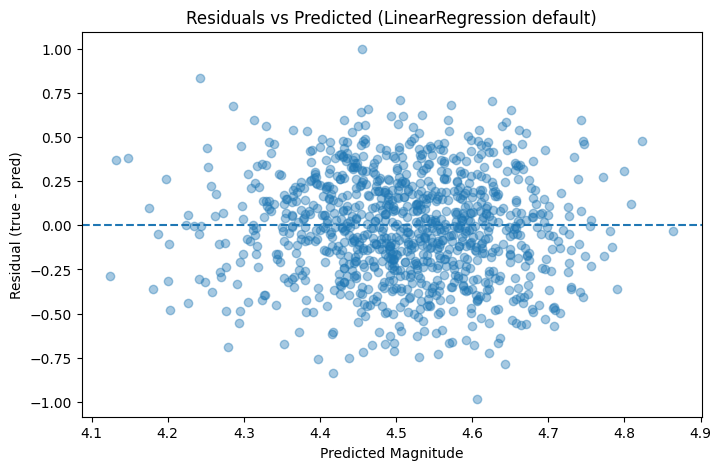

In [8]:
plt.figure(figsize=(8,5))
resid_default = y_test - pred_default
plt.scatter(pred_default, resid_default, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.title('Residuals vs Predicted (LinearRegression default)')
plt.xlabel('Predicted Magnitude')
plt.ylabel('Residual (true - pred)')
plt.show()


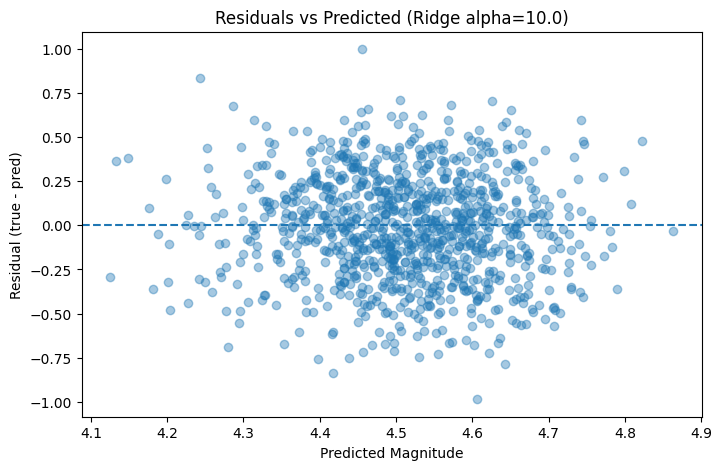

In [16]:

plt.figure(figsize=(8,5))
resid_ridge = y_test - pred_ridge
plt.scatter(pred_ridge, resid_ridge, alpha=0.4)
plt.axhline(0, linestyle='--')
plt.title(f'Residuals vs Predicted (Ridge alpha={grid.best_params_["ridge__alpha"]})')
plt.xlabel('Predicted Magnitude')
plt.ylabel('Residual (true - pred)')
plt.show()
